# Last Cycle
Now that the cycle stabilized we can cycle one more time to track relevant quantities:
- Mutual Information
- Work
- Heat
- Internal Energy (?)

In [1]:
include("./modules/OpticalCavity.jl")
include("./modules/Thermodynamics.jl")
include("./modules/Phaseonium.jl")
include("./modules/BosonicOperators.jl")
include("./modules/Measurements.jl")

using LinearAlgebra
using SparseArrays
using ProgressBars
using Plots; gr()
using LaTeXStrings
using TOML
# Saving the output matrix
using Serialization
using NPZ

using .OpticalCavity
using .Thermodynamics
using .Phaseonium
using .BosonicOperators
using .Measurements

include("./src/RoutineFunctions.jl")

":)"

In [28]:
const THERMALIZED = false
const PLOT_EVO = true
dir = "cascade_15D_I3_benchmark";
config = ""
try
    config = TOML.parsefile(dir * "/config.toml")
catch e
    println("Error reading configuration: $e")
else
    println(config["description"])
end

const NDIMS = config["dims"]
const Ω = config["omega"]
const Δt = config["dt"]

const T_initial = config["T_initial"]

# Create a Cavity
const mass = config["cavity"]["mass"]
const surface = config["cavity"]["surface"]
const α0 = config["cavity"]["alpha"]
const l_min = config["cavity"]["min_length"]
const l_max = config["cavity"]["max_length"]
const expanding_force = config["cavity"]["external_force"]
cavity1 = Cavity(mass, surface, l_min, l_max, α0, expanding_force)
cavity2 = Cavity(mass, surface, l_min, l_max, α0, expanding_force)
ω_max = α0 / l_min
ω_min = α0 / l_max

# The system starts contracted, where the frequency is maximum
ρt = thermalstate(NDIMS, ω_max, T_initial)
println(
    "Initial Temperature of the Cavity:
    $(Measurements.temperature(ρt, ω_max))")

# Jump Operators
a = BosonicOperators.destroy(NDIMS)
ad = BosonicOperators.create(NDIMS)

# Create Phaseonium atoms
# For thermal (diagonal) phaseoniums, the Master Equation is the same as having ϕ=π/2
# Heating at minimum length
const ϕ_h = π / config["phaseonium"]["phi_hot"]
const T_hot = config["phaseonium"]["T_hot"]
α_h = Phaseonium.alpha_from_temperature(T_hot, ϕ_h, ω_max) 

const ga_h, gb_h = Phaseonium.dissipationrates(α_h, ϕ_h)
println(
    "Apparent Temperature carried by Hot Phaseonium atoms: 
    $(Phaseonium.finaltemperature(ω_max, ga_h, gb_h))")

bosonic_h = bosonic_operators(Ω, Δt, NDIMS)

# Cooling at maximum length
const ϕ_c = π / config["phaseonium"]["phi_cold"]
const T_cold = config["phaseonium"]["T_cold"]
α_c = Phaseonium.alpha_from_temperature(T_cold, ϕ_c, ω_min) 

const ga_c, gb_c = Phaseonium.dissipationrates(α_c, ϕ_c)
println(
    "Apparent Temperature carried by Cold Phaseonium atoms: 
    $(Phaseonium.finaltemperature(ω_min, ga_c, gb_c))")

bosonic_c = bosonic_operators(Ω, Δt, NDIMS);

total_cycles = config["loading"]["past_cycles"]
system_evolution = []
;

Simulation 5 - 20D - Fast thermalization - High entanglement: what happens to the efficiency?

Initial Temperature of the Cavity:
    1.9999999999999998
Apparent Temperature carried by Hot Phaseonium atoms: 
    199.9999999999968
Apparent Temperature carried by Cold Phaseonium atoms: 
    0.0


### Load or Create State

In [29]:
state = load_or_create(dir, config)
;
# Check number of photons and cutoff
ρ₁ = partial_trace(real(state.ρ), (NDIMS, NDIMS), 1)
println("Average Photons: $(tr(ρ₁ * ad*a))")
println("Last Element $(ρ₁[end])")

Starting with a new cascade system (contracted)
Initial Temperature of the Cavity:
            1.9999999999999998
Average Photons: 0.26243430942545226
Last Element 8.653979258015589e-14


In [30]:
if !THERMALIZED
    # Reinitialize memory
    state.ρ₁_evolution = [] 
    state.ρ₂_evolution = []
    state.c₁_evolution = []
    state.c₂_evolution = [];
end

Any[]

### Cycle

Cycle 1
Isochoric Stroke


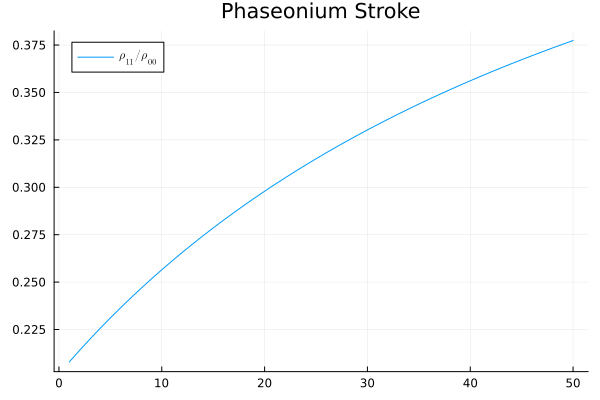

Adiabatic Stroke


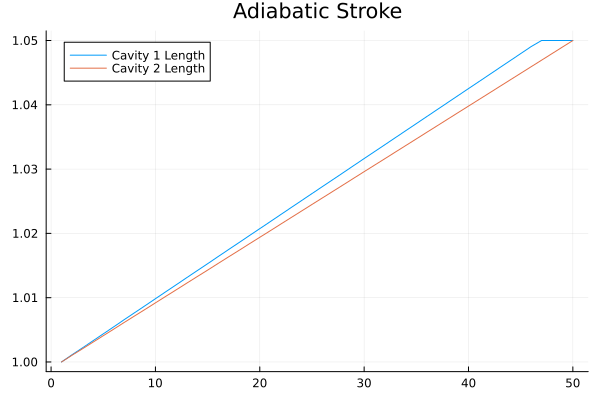

Isochoric Stroke


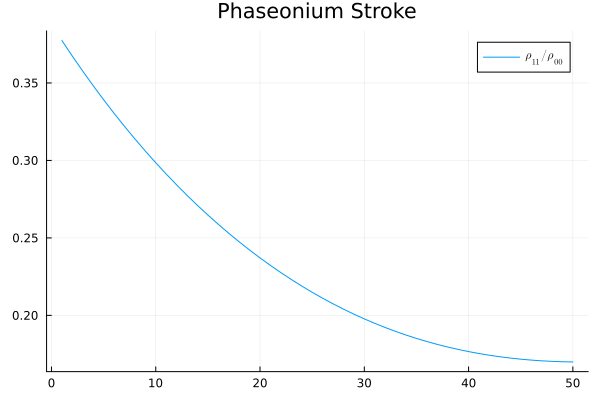

Adiabatic Stroke


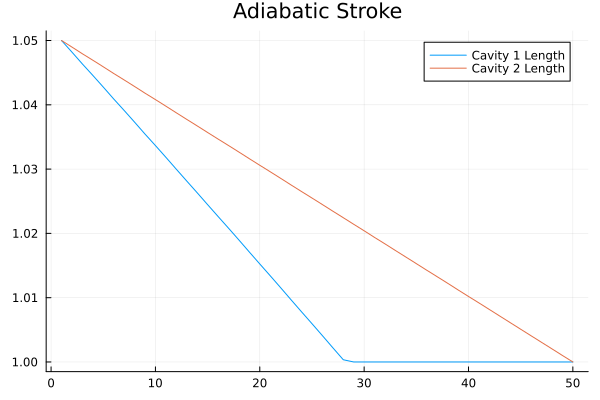

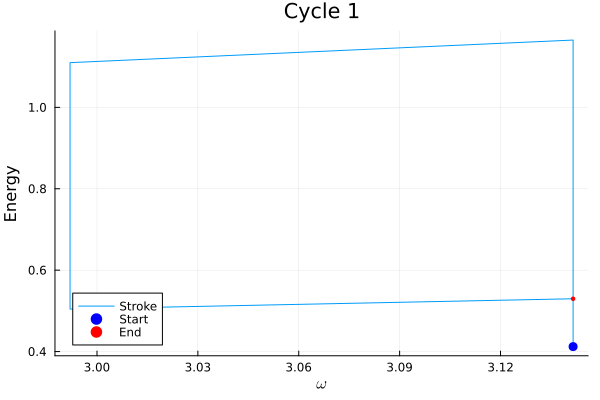

Cycle 2
Isochoric Stroke


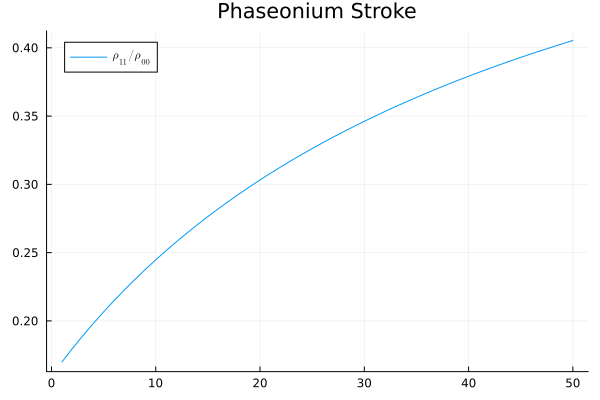

Adiabatic Stroke


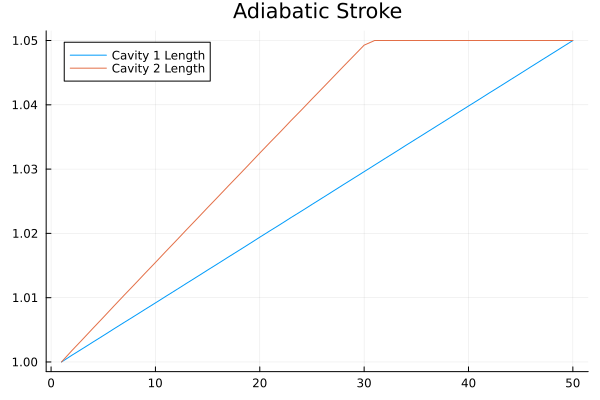

Isochoric Stroke


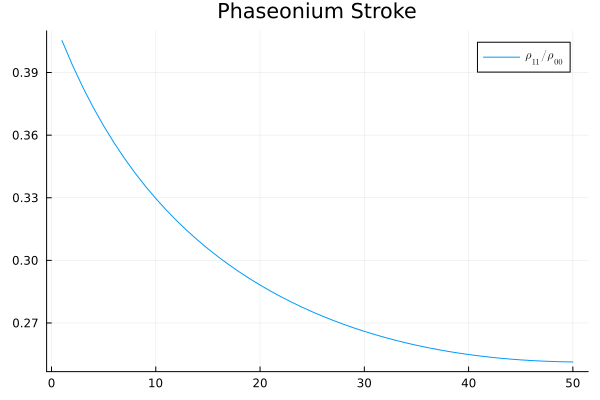

Adiabatic Stroke


LoadError: One cavity is almost still

In [31]:
isochore_time = config["stroke_time"]["isochore"]
isochore_samplings = config["samplings"]["isochore"]
adiabatic_time = config["stroke_time"]["adiabatic"]
adiabatic_samplings = config["samplings"]["adiabatic"]

total_cycle_time = isochore_samplings * 2 + 2 * adiabatic_samplings
cycle_steps = []  # This keeps track of the total time of each stroke

if !THERMALIZED
    for t in 1:config["cycles"]
        println("Cycle $t")
        state, system_evolution = cycle(
            state, Δt, system_evolution, cycle_steps, isochore_time, isochore_samplings, adiabatic_time, adiabatic_samplings);
        total_cycles += 1

        if PLOT_EVO
            x = state.ρ₁_evolution[end-total_cycle_time+1:end] # last cycle
            y = state.c₁_evolution[end-total_cycle_time+1:end] # last cycle
            g = measure_and_plot("Frequency", "Energy", x, y, "Cycle $t"; α=π)
            display(g)
        end
    end

    serialize(dir * "/state_$(total_cycles)C.jl", state)
    serialize(dir * "/state_evolution_$(total_cycles)C.jl", system_evolution)
else
    system_evolution = deserialize(dir * "/state_evolution_$(total_cycles)C.jl");
end
println("Cycle len: $(size(system_evolution)[1] / total_cycles) steps")

### Check stability of the Cycle

(350,)


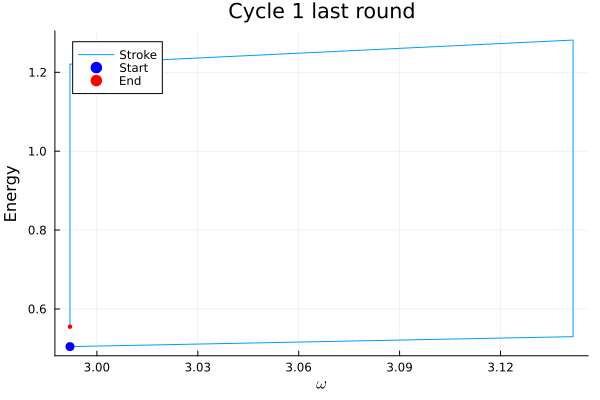

In [6]:
println(size(system_evolution))
state_evolution = state.ρ₁_evolution[end-total_cycle_time+1:end] # last cycle
cavity_evolution = state.c₁_evolution[end-total_cycle_time+1:end] # last cycle
g = measure_and_plot("Frequency", "Energy", state_evolution, cavity_evolution, "Cycle 1 last round"; α=π)

In [7]:
savefig(g, dir * "/last_cycle.png")

"/home/pmxfa13/phaseonium/thermophaseonium/julia/cascade_20D_I1/last_cycle.png"

## Measure the Evolving Cascade State

## Entropy

In [8]:
SA = [Measurements.entropy_vn(ρ) for ρ in state.ρ₁_evolution]
SB = [Measurements.entropy_vn(ρ) for ρ in state.ρ₂_evolution]

SAB = [Measurements.entropy_vn(ρ) for ρ in system_evolution];

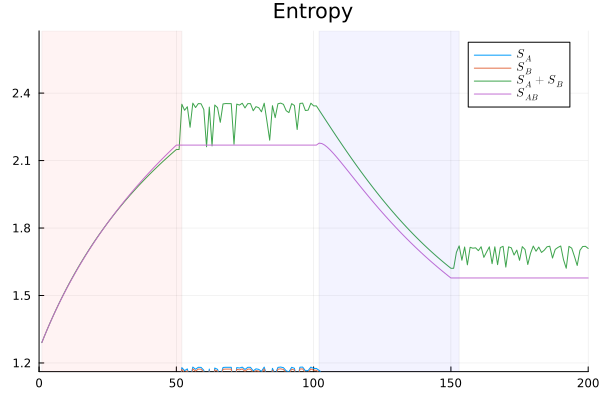

In [9]:
g = plot([SA, SB, SA+SB, SAB], label=[L"S_A" L"S_B" L"S_A+S_B" L"S_{AB}"], title="Entropy")
plot_strokes_overlays(g, SAB, isochore_samplings, adiabatic_samplings; x_max=total_cycles*total_cycle_time)

In [10]:
# savefig(g, dir * "/entropy.png")
# savefig(g, dir * "/entropy.pdf")

### Mutual Information
Measure the correlation between the two cavities during the cycle

In [11]:
I = SA + SB - SAB;

Mutual Information goes down to: -0.019563261341701832


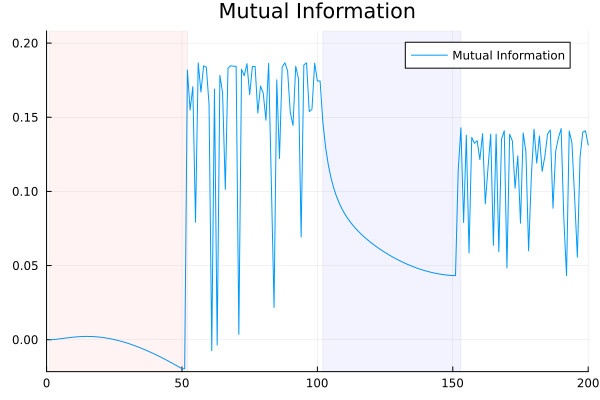

In [12]:
println("Mutual Information goes down to: $(minimum(I))")
g = plot(I, label="Mutual Information", title="Mutual Information")
plot_strokes_overlays(g, I, isochore_samplings, adiabatic_samplings; x_max=total_cycles*total_cycle_time)

In [13]:
# savefig(g, dir * "/mutual_info.png")
# savefig(g, dir * "/mutual_info.pdf")

### Heat
By Alicki definition
$$
Q = \text{Tr}\{\Delta\rho H(\omega)\} = \text{Tr}\{\rho_{n+1}H(\omega)\} - \text{Tr}\{\rho_{n}H(\omega)\} 
$$
Here heating and cooling happens with two different cavity lengths (two different $\omega$)

In [14]:
ω₁_evolution = [α0 / l1 for l1 in state.c₁_evolution]
ω₂_evolution = [α0 / l2 for l2 in state.c₂_evolution]
# Expectation value of the Hamiltonians
energies_s₁ = [Measurements.avg_E(ρ, ω) for (ρ, ω) in zip(state.ρ₁_evolution, ω₁_evolution)]
energies_s₂ = [Measurements.avg_E(ρ, ω) for (ρ, ω) in zip(state.ρ₂_evolution, ω₂_evolution)]
# Heat absorbed and given
q₁ = [energies_s₁[i+1] - energies_s₁[i] for i in 1:length(energies_s₁)-1]
q₂ = [energies_s₂[i+1] - energies_s₂[i] for i in 1:length(energies_s₂)-1]

g_heat = plot(q₁+q₂, label=L"Q_{AB}", linewidth=2, linestyle=:dashdot)
plot!(q₁, label=L"Q_A")
plot!(q₂, label=L"Q_B")
plot_strokes_overlays(g_heat, q₁+q₂, isochore_samplings-2, adiabatic_samplings-1; x_max=total_cycle_time)

LoadError: MethodError: no method matching isless(::ComplexF64, ::ComplexF64)
The function `isless` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  isless([91m::Missing[39m, ::Any)
[0m[90m   @[39m [90mBase[39m [90m[4mmissing.jl:87[24m[39m
[0m  isless(::Any, [91m::Missing[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mmissing.jl:88[24m[39m
[0m  isless([91m::Pkg.Resolve.FieldValue[39m, [91m::Pkg.Resolve.FieldValue[39m)
[0m[90m   @[39m [32mPkg[39m [90m~/.local/julia-1.11.2/share/julia/stdlib/v1.11/Pkg/src/Resolve/[39m[90m[4mfieldvalues.jl:45[24m[39m
[0m  ...


### Work
by Alicki definition
$$
W = \text{Tr}\{\rho\Delta H\} = \text{Tr}\{\rho H(\omega_{n+1})\} - \text{Tr}\{\rho H(\omega_n)\} 
$$
Here $\rho$ should always be the same (when written in the eigenbasis of its respective Hamiltonian.

In [15]:
# Expectation value of the Hamiltonians
ρ = state.ρ₁_evolution[isochore_samplings + 1]
energies_s₁ = [Measurements.avg_E(ρ, ω) for ω in ω₁_evolution]
energies_s₂ = [Measurements.avg_E(ρ, ω) for ω in ω₂_evolution]
# Work done on the system and from it
w₁ = [energies_s₁[i+1] - energies_s₁[i] for i in 1:length(energies_s₁)-1]
w₂ = [energies_s₂[i+1] - energies_s₂[i] for i in 1:length(energies_s₂)-1]
net_w = sum(w₁+w₁)

g_work = plot(-w₁-w₂, label=L"W_{AB}", linewidth=2, linestyle=:dashdot)
plot!(-w₁, label=L"W_1")
plot!(-w₂, label=L"W_2")
plot!([0, total_cycle_time], [-net_w, -net_w], label="Total Work")
plot_strokes_overlays(g_work, -w₁-w₁, isochore_samplings, adiabatic_samplings; x_max=total_cycle_time)

LoadError: MethodError: no method matching isless(::Float64, ::ComplexF64)
The function `isless` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  isless([91m::Missing[39m, ::Any)
[0m[90m   @[39m [90mBase[39m [90m[4mmissing.jl:87[24m[39m
[0m  isless(::Any, [91m::Missing[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mmissing.jl:88[24m[39m
[0m  isless(::AbstractFloat, [91m::ForwardDiff.Dual{Ty}[39m) where Ty
[0m[90m   @[39m [32mForwardDiff[39m [90m~/.julia/packages/ForwardDiff/UBbGT/src/[39m[90m[4mdual.jl:149[24m[39m
[0m  ...


We can as well compute the work ``classically'' knowing the movement of the cavity wall and the force acting on it
$$
W = F \Delta l = p S \Delta l
$$

Net work: 0.08975429464687917


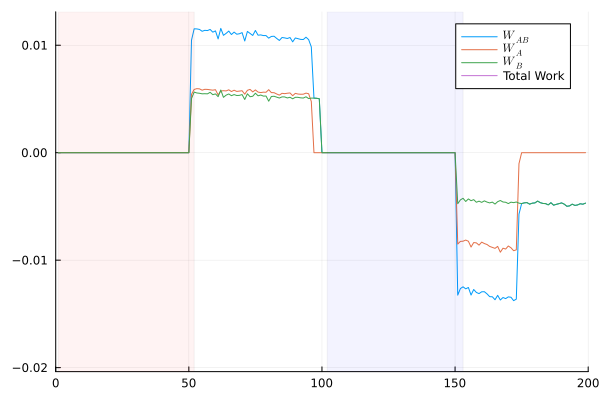

In [16]:
identity_matrix = spdiagm(ones(NDIMS))
# Pressure Operator
function pressure_operator(ω, t, adiabatic_samplings, a, ad)
    t = t*adiabatic_samplings
    2 * a * ad  - a * a * exp(-2*im*ω*t) - ad * ad * exp(2*im*ω*t)
end
π₁_evolution = [pressure_operator(ω₁_evolution[i], i, adiabatic_samplings, a, ad)
    for i in 1:total_cycle_time]
π₂_evolution = [pressure_operator(ω₂_evolution[i], i, adiabatic_samplings, a, ad)
    for i in 1:total_cycle_time]
s1 = cavity1.surface
s2 = cavity2.surface
p1 = [Measurements.pressure(ρ, π₁, identity_matrix, α0, l, s1)
    for (ρ, π₁, l) in zip(state.ρ₁_evolution, π₁_evolution, state.c₁_evolution)]
p2 = [Measurements.pressure(ρ, π₂, identity_matrix, α0, l, s2)
    for (ρ, π₂, l) in zip(state.ρ₂_evolution, π₂_evolution, state.c₂_evolution)]

# Optomechanical Work
w₁ = [p*s1*(state.c₁_evolution[i+1]-state.c₁_evolution[i]) for (p, i) in zip(p1, 1:total_cycle_time-1)]
w₂ = [p*s2*(state.c₂_evolution[i+1]-state.c₂_evolution[i]) for (p, i) in zip(p2, 1:total_cycle_time-1)]
net_w = sum(w₁+w₂)
println("Net work: $net_w")

g_press = plot(w₁+w₂, label=L"W_{AB}")
plot!(w₁, label=L"W_{A}")
plot!(w₂, label=L"W_{B}")
plot!([0, total_cycle_time], [sum(w₁), sum(w₁)], label="Total Work")
plot_strokes_overlays(g_press, w₁+w₁, isochore_samplings, adiabatic_samplings; x_max=total_cycle_time)

### Efficiency
We can now compute efficiency as
$$
\eta = \frac{|W_\text{net}|}{Q_\text{in}}
$$

As a reference we can use Carnot Efficiency
$$
\eta_C = 1 - \frac{T_c}{T_h}
$$
or better the Curzon-Ahlborn Efficiency
$$
\eta_{CA} = 1 - \left(\frac{T_c}{T_h}\right)^{1/2}
$$

In [17]:
# At what temperatures the machine operates?
temperatures_1 = [Measurements.temperature(ρ, ω) for (ρ, ω) in zip(state.ρ₁_evolution, ω₁_evolution)]
temperatures_2 = [Measurements.temperature(ρ, ω) for (ρ, ω) in zip(state.ρ₂_evolution, ω₂_evolution)]

T₁_hot = round(maximum(temperatures_1), digits=3)
T₁_cold = round(minimum(temperatures_1), digits=3)
println("Cavity A operates between the temperatures:\n $T₁_hot - $T₁_cold")
T₂_hot = round(maximum(temperatures_2), digits=3)
T₂_cold = round(minimum(temperatures_2), digits=3)
println("Cavity B operates between the temperatures:\n $T₂_hot - $T₂_cold")

T_cold_pred = - ω₁_evolution[end-adiabatic_samplings+2] / log(ga_c/gb_c)
T_hot_pred = - ω₁_evolution[1] / log(ga_h/gb_h)
# T_cold_pred = - ω₁_evolution[end] / log(ga_c/(1-ga_c/2))

Cavity A operates between the temperatures:
 3.936 - 2.0
Cavity B operates between the temperatures:
 4.08 - 2.0


199.9999999999968

In [18]:
η₁C = round(1 - T₁_cold / T₁_hot, digits=3)
η₁CA = round(1 - sqrt(T₁_cold / T₁_hot), digits=3)
η₂C = round(1 - T₂_cold / T₂_hot, digits=3)
η₂CA = round(1 - sqrt(T₂_cold / T₂_hot), digits=3)
# Classic Efficiency (with classical temperatures)
T₁_hot_cl = round(classic_temp(T₁_hot, ω_max, ϕ_h), digits=3)
T₁_cold_cl = round(classic_temp(T₁_cold, ω_min, ϕ_c), digits=3)
T₂_hot_cl = round(classic_temp(T₂_hot, ω_max, ϕ_h), digits=3)
T₂_cold_cl = round(classic_temp(T₂_cold, ω_min, ϕ_c), digits=3)
η₁Cl = round(1 - T₁_cold_cl / T₁_hot_cl, digits=3)
η₂Cl = round(1 - T₂_cold_cl / T₂_hot_cl, digits=3)

net_w = abs(net_w)
q₁_in = sum(q₁[1:isochore_samplings])
net_w₁ = sum(w₁)
q₂_in = sum(q₂[1:isochore_samplings])
net_w₂ = sum(w₂)

η₁ = round(net_w₁ / q₁_in, digits=3)
η₂ = round(net_w₂ / q₂_in, digits=3)

string_out = """
    Cavity  | ηC \t| ηCA \t| η \t| ηCl \t| Tʰ \t| Tᶜ \t| TʰCl \t| TᶜCl
    A       | $η₁C\t| $η₁CA\t| $η₁\t| $η₁Cl\t| $T₁_hot\t| $T₁_cold\t| $T₁_hot_cl\t| $T₁_cold_cl
    B       | $η₂C\t| $η₂CA\t| $η₂\t| $η₂Cl\t| $T₂_hot\t| $T₂_cold\t| $T₂_hot_cl\t| $T₂_cold_cl
"""
println(string_out)

    Cavity  | ηC 	| ηCA 	| η 	| ηCl 	| Tʰ 	| Tᶜ 	| TʰCl 	| TᶜCl
    A       | 0.492	| 0.287	| 0.079 - 0.0im	| 0.466	| 3.936	| 2.0	| 3.936	| 2.101
    B       | 0.51	| 0.3	| 0.041 - 0.0im	| 0.485	| 4.08	| 2.0	| 4.08	| 2.101



In [19]:
csv_out = replace(string_out, "|"=>",")
csv_out = replace(csv_out, "\t"=>"")
csv_out = replace(csv_out, " "=>"")

open(dir * "/results.csv", "w") do f
    write(f, csv_out)
end
;

## Save Last Cycle

In [20]:
last_evolution = system_evolution[end-total_cycle_time+1:end]
ω₁_evolution = [α0 / l1 for l1 in state.c₁_evolution[end-total_cycle_time+1:end]]
ω₂_evolution = [α0 / l2 for l2 in state.c₂_evolution[end-total_cycle_time+1:end]]

dict_evolution = Dict(string(i)=>last_evolution[i] for i in 1:length(last_evolution))
cycle_steps = Vector{Float64}(cycle_steps)

npzwrite(dir * "/cycle_steps.npy", cycle_steps[end-3:end])
npzwrite(dir * "/cavities_evolution_1cycle.npz", c1=ω₁_evolution, c2=ω₂_evolution)
npzwrite(dir * "/cascade_evolution_1cycle.npz", dict_evolution)

In [21]:
npzwrite(dir * "/cycle_steps_3.npy", cycle_steps[end-3:end])


In [22]:
partial_trace(last_evolution[1], (NDIMS, NDIMS), 1)

LoadError: MethodError: no method matching partial_trace(::Matrix{ComplexF64}, ::Tuple{Int64, Int64}, ::Int64)
The function `partial_trace` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  partial_trace([91m::Matrix{Float64}[39m, ::Tuple{Int64, Int64}, ::Int64)
[0m[90m   @[39m [36mMain[39m [90m~/phaseonium/thermophaseonium/julia/src/[39m[90m[4mRoutineFunctions.jl:129[24m[39m


In [23]:
npzread(dir * "/cycle_steps.npy")

4-element Vector{Float64}:
 28.92000000000172
  3.2
 21.7400000000006
  3.2